In [1]:
import autoencodeSVJ.evaluate as ev
import autoencodeSVJ.utils as utils
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
import numpy as np

Using TensorFlow backend.


In [124]:
space = [
    Integer(2, 30, name='target_dim'),
    Integer(0, 1, name='hlf'),
    Real(0.05, 0.5, name='val_split'),
    Real(1e-4, 1e-1, name='learning_rate', prior='log-uniform'), 
    Categorical(['mae', 'mse'], name='loss'),
    Integer(3, 4, name='eflow_base')
]

In [125]:
filtered = utils.summary().cfilter([elt.name for elt in space] + ["*auc"])

keep = filtered.copy()
for elt in space:
    if isinstance(elt, Categorical):
        keep = keep[keep[elt.name].isin(elt.categories)]
    else:
        keep = keep[keep[elt.name].between(*elt.bounds)]
        if isinstance(elt, Integer):
            keep = keep[keep[elt.name].apply(lambda x: float(x).is_integer())]

aucs = keep.loc[:,~keep.columns.isin([elt.name for elt in space])]

x0 = np.asarray([keep[item.name].values for item in space]).T.tolist()
y0 = map(lambda x: 1 - x,aucs.max(axis=1).tolist())
# x0 = [list(keep [item.name].values) for item in space]
# y0 = auc.max(axis=1).tolist()

In [ ]:
random_state = np.random.randint(0, 100000)

@use_named_args(space)
def objective(**X):
    print "computing configuration {}".format(X)
    
    # minimize 1 - auc
    auc = 1. - ev.ae_train(
        qcd_path='data/background/base_{}/*.h5'.format(X['eflow_base']),
        signal_path="data/signal/base_{}/*.h5".format(X['eflow_base']),
        epochs=100,
        hlf=bool(X['hlf']),
        target_dim=X['target_dim'],
        val_split=X['val_split'],
        learning_rate=X['learning_rate'],
        optimizer='adam',
        loss=X['loss'],
        seed=random_state,
        verbose=0,
    )
    
    print "Max AUC:", 1 - auc
    return auc

results = gp_minimize(objective, space, verbose=1, x0=x0, y0=y0, n_calls=20, n_random_starts=5, random_state=random_state)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0007
Function value obtained: 0.0037
Current minimum: 0.0037
Iteration No: 2 started. Evaluating function at random point.
computing configuration {'loss': 'mse', 'val_split': 0.11901833535197946, 'learning_rate': 0.0003065243605129555, 'target_dim': 4, 'eflow_base': 4, 'hlf': 1}
Max AUC: 0.177661113089
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 254.3959
Function value obtained: 0.1777
Current minimum: 0.0037
Iteration No: 3 started. Evaluating function at random point.
computing configuration {'loss': 'mse', 'val_split': 0.42265227781494957, 'learning_rate': 0.00174687379638172, 'target_dim': 26, 'eflow_base': 4, 'hlf': 1}
Max AUC: 0.015609938215
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 142.8773
Function value obtained: 0.0156
Current minimum: 0.0037
Iteration No: 4 started. Evaluating function at random

In [14]:
utils

<module 'autoencodeSVJ.utils' from '/afs/cern.ch/user/l/llepotti/.local/lib/python2.7/site-packages/autoencodeSVJ/utils.pyc'>

In [ ]:
from skopt.plots import plot_convergence

plot_convergence(results)


In [ ]:
print("Best parameters: \
\nbest_hidden_layers = {} \
\nbest_initial_nodes = {} \
\nbest_dropout = {} \
\nbest_learning_rate = {}".format(results.x[0],
                                 results.x[1],
                                 results.x[2],
                                 results.x[3]))

In [11]:
# utils.summary().cfilter(["*auc*", "target_dim", "hlf", 'epo*'])

,epochs,hlf,mae_auc,mse_auc,target_dim
0,1,False,0.862698,0.84429,3
1,1,False,0.938824,0.932237,3
2,100,False,0.993498,0.994219,8
3,5,False,0.982221,0.983467,10
4,5,False,0.987275,0.988165,10
5,10,1,0.963714,0.964086,15
6,100,False,0.987723,0.988752,6
7,5,True,0.731472,0.743457,9
8,5,False,0.987536,0.98731,15


In [17]:
utils.get_cutflow_table("../../../data/ttbar/*cutflow*")

,cut_name,n_events,abs eff.,rel eff.
0,no cut,83949,100.00,100.00
1,0 Passing Leptons,55768,66.43,66.43
2,n Jets > 1,55664,66.31,99.81
3,abs jet Etas < 2.4,44505,53.01,79.95
4,abs DeltaEta < 1.5,33185,39.53,74.56
5,MET/M_T > 0.15,25708,30.62,77.47
6,Jet PT > 200,327,0.39,1.27
7,Dijet veto,327,0.39,100.00
8,M_T > 1500,5,0.01,1.53
9,MET/M_T > 0.25,3,0.00,60.00


In [10]:
from tqdm import tqdm
import numpy as np
import math
import os
import argparse
import sys
import time
from traceback import format_exc
import h5py
import ROOT as rt
from collections import OrderedDict as odict
import energyflow as ef

DELPHES_DIR = os.environ["DELPHES_DIR"]
rt.gSystem.Load("{}/lib/libDelphes.so".format(DELPHES_DIR))
rt.gInterpreter.Declare('#include "{}/include/modules/Delphes.h"'.format(DELPHES_DIR))
rt.gInterpreter.Declare('#include "{}/include/classes/DelphesClasses.h"'.format(DELPHES_DIR))
rt.gInterpreter.Declare('#include "{}/include/classes/DelphesFactory.h"'.format(DELPHES_DIR))
rt.gInterpreter.Declare('#include "{}/include/ExRootAnalysis/ExRootTreeReader.h"'.format(DELPHES_DIR))


f = rt.TFile("/eos/project/d/dshep/TOPCLASS/ZprimeDark_2000GeV_13TeV_PU40_OLD/ZprimeDark_2000GeV_13TeV_PU40_42.root")
tree = f.Get("Delphes")

# pdict = {}
# tree.SetBranchStatus("*", 0)
# tree.SetBranchStatus("Particle.PID", 1)
# tree.SetBranchStatus("Particle.Status", 1)

# p = tree.GetLeaf("Particle.PID")
# s = tree.GetLeaf("Particle.Status")

# total = 0
# for n in tqdm(range(0, tree.GetEntries())):
#     if tree.GetEntry(i):
#         for i in range(min(p.GetLen(), s.GetLen())):
#             total += 1
#             k = p.GetValue(i)
#             v = s.GetValue(i)

#             if k not in pdict:
#                 pdict[k] = {}
#             if v not in pdict[k]:
#                 pdict[k][v] = 0
#             pdict[k][v] += 1


In [11]:
tree.Draw("Particle.PID", "", "goff")

7688211L

In [7]:
def merge_files(path, out_name, treename="Delphes"):
    chain = rt.TChain(treename)
    for f in glob.glob(path):
        chain.Add(f)
    chain.Merge(out_name)

In [8]:
merge_files("/eos/project/d/dshep/TOPCLASS/ZprimeDark_2000GeV_13TeV_PU40/*.root", 'fixed_nu.root')
merge_files("/eos/project/d/dshep/TOPCLASS/ZprimeDark_2000GeV_13TeV_PU40_NoNu/*.root", 'no_nu.root')

Info in <TBranchElement::InitializeOffsets>: TTree created with an older schema, some data might not be copied in 'slow-cloning' mode; fast-cloning should have the correct result. 'Dxy' is missing when constructing the branch 'EFlowTrack'. 
Info in <TBranchElement::InitializeOffsets>: TTree created with an older schema, some data might not be copied in 'slow-cloning' mode; fast-cloning should have the correct result. 'SDxy' is missing when constructing the branch 'EFlowTrack'. 
Info in <TBranchElement::InitializeOffsets>: TTree created with an older schema, some data might not be copied in 'slow-cloning' mode; fast-cloning should have the correct result. 'Dxy' is missing when constructing the branch 'EFlowTrack'. 
Info in <TBranchElement::InitializeOffsets>: TTree created with an older schema, some data might not be copied in 'slow-cloning' mode; fast-cloning should have the correct result. 'SDxy' is missing when constructing the branch 'EFlowTrack'. 


In [12]:

def get_particle_statuses(filename, plot=False):
    import pandas as pd
    import matplotlib.pyplot as plt
    import os
    import ROOT as rt

    DELPHES_DIR = os.environ["DELPHES_DIR"]
    rt.gSystem.Load("{}/lib/libDelphes.so".format(DELPHES_DIR))
    rt.gInterpreter.Declare('#include "{}/include/modules/Delphes.h"'.format(DELPHES_DIR))
    rt.gInterpreter.Declare('#include "{}/include/classes/DelphesClasses.h"'.format(DELPHES_DIR))
    rt.gInterpreter.Declare('#include "{}/include/classes/DelphesFactory.h"'.format(DELPHES_DIR))
    rt.gInterpreter.Declare('#include "{}/include/ExRootAnalysis/ExRootTreeReader.h"'.format(DELPHES_DIR))


    f = rt.TFile(filename)
    tree = f.Get("Delphes")
    
    parr = np.zeros((tree.Draw("Particle.PID", "", "goff"), 2))
    total = 0
    for i in tqdm(range(tree.GetEntries())):
        tree.GetEntry(i)
        for p in tree.Particle:
            parr[total,:] = p.PID, p.Status
            total += 1

    df = pd.DataFrame(parr, columns=["PID", "Status"])
    new = df[abs(df.PID) > 4900100]
    counts = new.PID.value_counts()
    pdict = odict()
    for c in counts.index:
        pdict[c] = dict(new[new.PID == c].Status.value_counts())

        
    converted = pd.DataFrame(pdict).T
    if plot:
        converted.plot.bar(stacked=True)
        plt.show()
    return converted

In [53]:
# old = get_particle_statuses/eos/project/d/dshep/TOPCLASS/DijetAnomaly/#pippo#y//ZprimeDark_2000GeV_13TeV_PU40_42.root")

In [15]:
normal = get_particle_statuses("/eos/project/d/dshep/TOPCLASS/ZprimeDark_2000GeV_13TeV_PU40_OLD/ZprimeDark_2000GeV_13TeV_PU40_42.root")

100%|██████████| 5000/5000 [01:02<00:00, 95.32it/s]


In [16]:
fixed_nu = get_particle_statuses("fixed_nu.root")

100%|██████████| 5000/5000 [01:10<00:00, 70.85it/s]


In [17]:
no_nu = get_particle_statuses("no_nu.root")

100%|██████████| 5000/5000 [01:14<00:00, 66.91it/s]


In [22]:
def pretty_plot(**fdict):

    cols = set().union(*[list(frame.columns) for frame in fdict.values()])
    parts = set().union(*[list(frame.index) for frame in fdict.values()])

    for name in fdict:
        fdict[name].fillna(0, inplace=True)

        for v in cols:
            if v not in fdict[name]:
                fdict[name][v] = 0
        for i in parts:
            if i not in fdict[name].index:
                fdict[name].loc[i] = 0

        fdict[name] = fdict[name][sorted(fdict[name].columns)]
        fdict[name].sort_index(inplace=True)

    for i,name in enumerate(fdict):
        ax = fdict[name].plot.bar(stacked=True, title=name, figsize=(8,8))
        ax.set_xlabel("PID")
        ax.set_ylabel("Count")

        legend = ax.get_legend()
        legend.set_title("Status")
    #     plt.suptitle(name)
        plt.show()
        
    return fdict


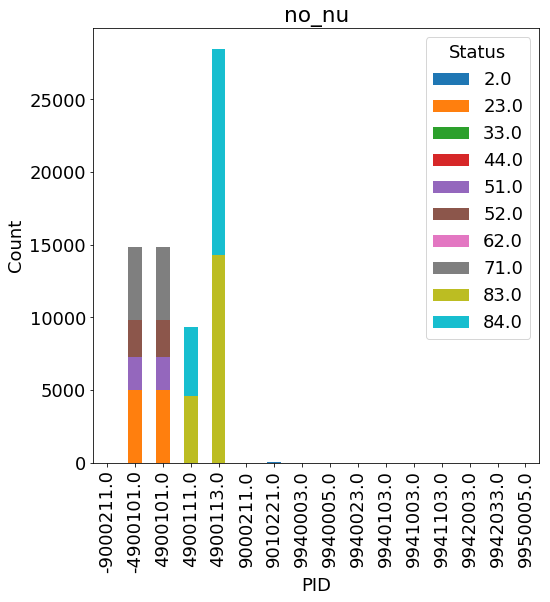

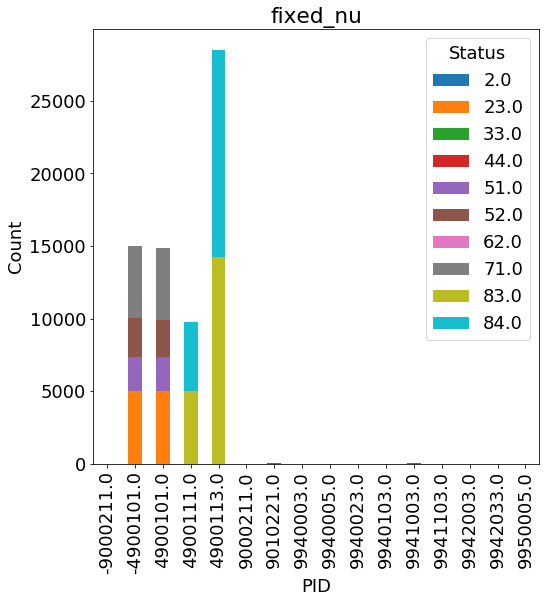

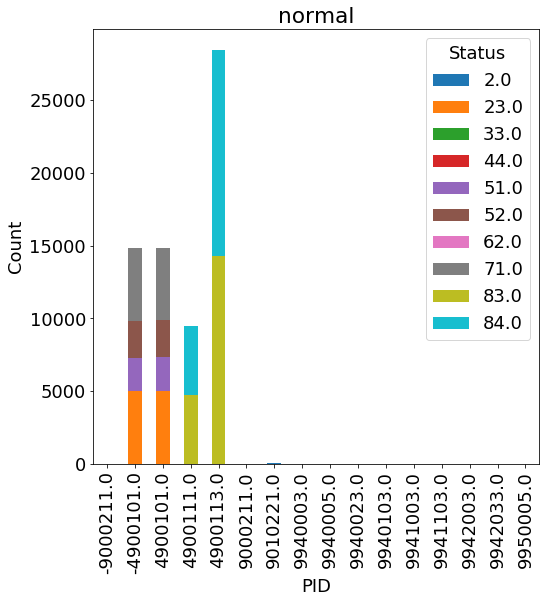

In [55]:
import matplotlib.pyplot as plt
fdict = pretty_plot(normal=normal.copy(), fixed_nu=fixed_nu.copy(), no_nu=no_nu.copy())

In [48]:
for name in fdict:
    keys = fdict.keys()
    keys.remove(name)
    for other in keys:
        print (fdict[other] == fdict[name]).all().all(), name, '==', other

False old_signal == no_nu
False old_signal == fixed_nu
True old_signal == normal
False no_nu == old_signal
False no_nu == fixed_nu
False no_nu == normal
False fixed_nu == old_signal
False fixed_nu == no_nu
False fixed_nu == normal
True normal == old_signal
False normal == no_nu
False normal == fixed_nu


In [61]:
(fdict['no_nu']/fdict['fixed_nu'])

,2.0,23.0,33.0,44.0,51.0,52.0,62.0,71.0,83.0,84.0
-9000211.0,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-4900101.0,NaN,1.0,NaN,NaN,0.981545,0.947917,NaN,1.0,NaN,NaN
4900101.0,NaN,1.0,NaN,NaN,0.965415,1.005556,NaN,1.0,NaN,NaN
4900111.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.921110,1.000631
4900113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999579,0.997965
9000211.0,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9010221.0,1.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9940003.0,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
9940005.0,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN
9940023.0,NaN,NaN,0.500000,0.125000,NaN,0.200000,0.500000,NaN,NaN,NaN


In [52]:
fdict['normal']

,2.0,23.0,33.0,44.0,51.0,52.0,62.0,71.0,83.0,84.0
-9000211.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-4900101.0,0.0,5000.0,0.0,0.0,2288.0,2525.0,0.0,5000.0,0.0,0.0
4900101.0,0.0,5000.0,0.0,0.0,2323.0,2541.0,0.0,5000.0,0.0,0.0
4900111.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4734.0,4762.0
4900113.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14276.0,14187.0
9000211.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9010221.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9940003.0,0.0,0.0,3.0,4.0,2.0,2.0,3.0,0.0,0.0,0.0
9940005.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9940023.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [202]:
[(n, v[2]) for n,v in fdict.items()]

[('old_signal', -4900101.0     0.0
   4900101.0     0.0
   4900111.0     0.0
   4900113.0     0.0
   9010221.0    54.0
   9940003.0     0.0
   9940103.0     0.0
   9941103.0     0.0
  Name: 2.0, dtype: float64), ('no_nu', -4900101.0    0.0
   4900101.0    0.0
   4900111.0    0.0
   4900113.0    0.0
   9010221.0    1.0
   9940003.0    0.0
   9940103.0    0.0
   9941103.0    0.0
  Name: 2.0, dtype: float64), ('fixed_nu', -4900101.0    0
   4900101.0    0
   4900111.0    0
   4900113.0    0
   9010221.0    0
   9940003.0    0
   9940103.0    0
   9941103.0    0
  Name: 2.0, dtype: int64), ('normal', -4900101.0     0.0
   4900101.0     0.0
   4900111.0     0.0
   4900113.0     0.0
   9010221.0    54.0
   9940003.0     0.0
   9940103.0     0.0
   9941103.0     0.0
  Name: 2.0, dtype: float64)]

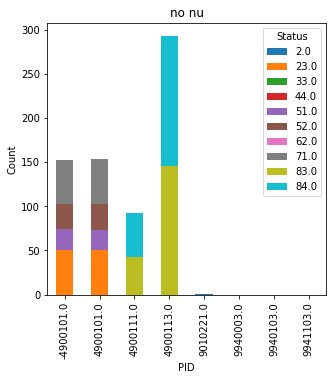

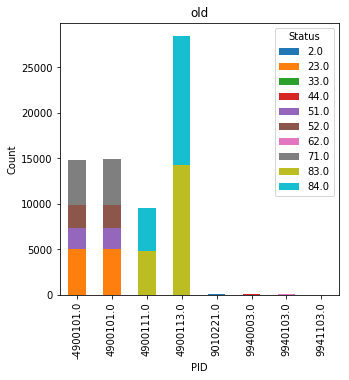

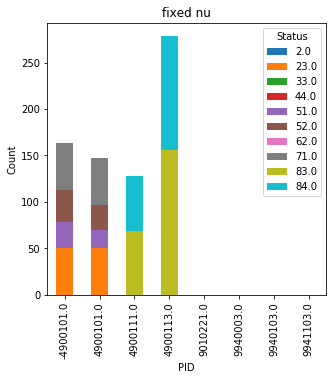

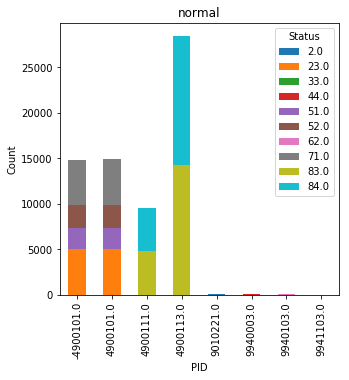

In [174]:
# fig, axs = plt.subplots(2,2, figsize=(12,17))
# axs = axs.ravel()



In [139]:
axes

In [86]:
from collections import OrderedDict as odict
keys = np.asarray(pdict.keys())
high = keys[np.abs(keys)  > 4900100]
new = odict([(k, pdict[k]) for k in high])
new 

OrderedDict([(-4900101.0, {23.0: 5000, 51.0: 2500, 52.0: 3750, 71.0: 5000}),
             (4900101.0, {23.0: 5000, 51.0: 2500, 52.0: 2500, 71.0: 5000}),
             (4900111.0, {83.0: 3750, 84.0: 7500}),
             (4900113.0, {83.0: 13750, 84.0: 17500})])

In [37]:
pdict

{-4900101.0: 16222,
 -20413.0: 3,
 -20313.0: 6,
 -20213.0: 3717,
 -10431.0: 1,
 -10423.0: 1,
 -10413.0: 5,
 -10323.0: 3,
 -10321.0: 1,
 -10313.0: 1,
 -10311.0: 1,
 -5222.0: 1,
 -5212.0: 1,
 -5132.0: 1,
 -5122.0: 6,
 -4332.0: 1,
 -4224.0: 1,
 -4222.0: 1,
 -4214.0: 3,
 -4124.0: 1,
 -4122.0: 15,
 -4114.0: 2,
 -4112.0: 2,
 -3334.0: 1234,
 -3324.0: 2,
 -3322.0: 1243,
 -3314.0: 3,
 -3312.0: 17,
 -3224.0: 12,
 -3222.0: 1278,
 -3214.0: 2473,
 -3212.0: 7445,
 -3122.0: 16180,
 -3114.0: 3710,
 -3112.0: 4985,
 -2224.0: 2512,
 -2214.0: 4984,
 -2212.0: 32534,
 -2114.0: 6219,
 -2112.0: 38684,
 -1114.0: 1285,
 -533.0: 13,
 -531.0: 16,
 -523.0: 2520,
 -521.0: 7473,
 -513.0: 4981,
 -511.0: 6233,
 -433.0: 1251,
 -431.0: 3737,
 -425.0: 2,
 -423.0: 2525,
 -421.0: 8808,
 -413.0: 2527,
 -411.0: 9953,
 -323.0: 18769,
 -321.0: 68702,
 -313.0: 22525,
 -311.0: 77329,
 -213.0: 89873,
 -211.0: 569635,
 -16.0: 15,
 -15.0: 9,
 -14.0: 6212,
 -13.0: 1269,
 -12.0: 8780,
 -11.0: 12483,
 -5.0: 26218,
 -4.0: 22653,
 -3.0:

In [36]:
br = tree.GetBranch("Particle_size")
tree.GetEntries()*tree.Particle_size

4225000L

In [8]:
[[tree.Particle[j].PID for j in range(tree.Particle.GetEntries())] for i in range(0, tree.GetEntries()) if tree.GetEntry(i)]

AttributeError: 'TObject' object has no attribute 'PID'

In [31]:
e = ae_evaluation(
    "eflow3_8_v0",
    qcd_path="data/background_old_full/background/base_3/*.h5",
    signal_path="data/signal/base_3/*.h5"
)
ep = ae_evaluation(
    "eflow3_8_v0",
    qcd_path="data/background_old_full/background/base_3/*.h5",
    signal_path="data/signal_old_full/signal/base_3/*.h5"
)

found 1 matches with search '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/summary/eflow3_8_v0.summary'
/t3home/llepotti/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/training_runs/eflow3_8_v0.pkl
/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/training_runs/eflow3_8_v0.pkl
loaded pickle file with path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/training_runs/eflow3_8_v0.pkl'
train_shell :: using saved model
found 1 matches with search '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/summary/eflow3_8_v0.summary'
/t3home/llepotti/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/training_runs/eflow3_8_v0.pkl
/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/training_runs/eflow3_8_v0.pkl
loaded pickle file with path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/

data_table :: plotting distrubution(s) for table(s) ['signal norm error', 'qcd test norm error']


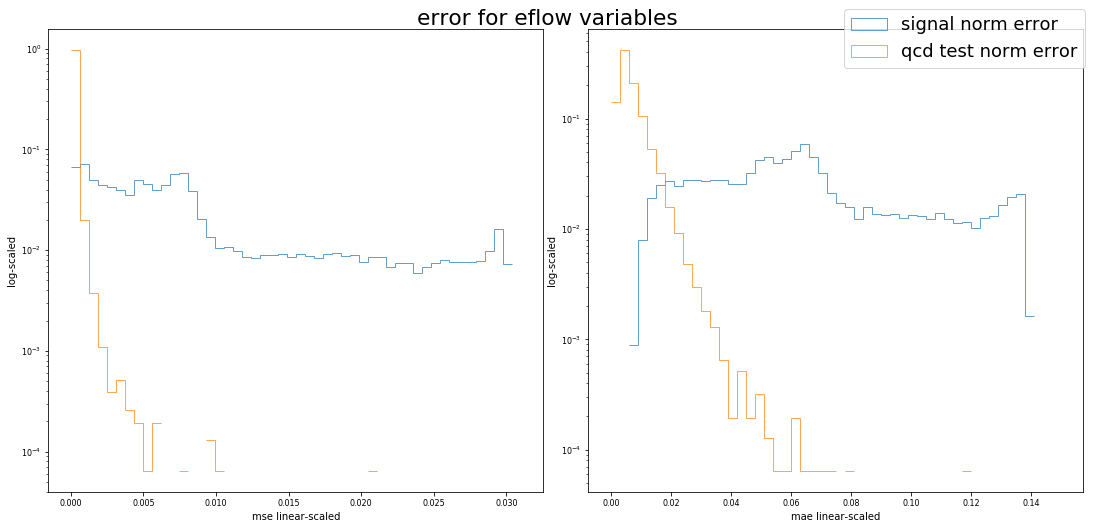

In [32]:
e.error(bins=50, rng=((0., 0.031), (0, 0.15)), yscale="log")

In [34]:
cuts = e.cut_at_threshold(0.005, metric='mse')
e.fill_cuts(cuts)

saving root file at /afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/module/autoencodeSVJ/SVJ_2000_0p3.root
saving root file at /afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/module/autoencodeSVJ/QCD.root


{'/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/module/autoencodeSVJ/QCD.root': [(array([  0,   0,   1,  27,  54,  45,  34,  36,  34,  27,  28,  31,  25,
           59, 136, 237, 342, 488, 624, 665, 708, 658, 644, 564, 478, 378,
          325, 260, 185, 128, 127,  93,  69,  45,  44,  33,  18,  31,  14,
           10,   7,   9,   7,   7,   2,   2,   0,   3,   2,   3]),
   array([    0.,    60.,   120.,   180.,   240.,   300.,   360.,   420.,
            480.,   540.,   600.,   660.,   720.,   780.,   840.,   900.,
            960.,  1020.,  1080.,  1140.,  1200.,  1260.,  1320.,  1380.,
           1440.,  1500.,  1560.,  1620.,  1680.,  1740.,  1800.,  1860.,
           1920.,  1980.,  2040.,  2100.,  2160.,  2220.,  2280.,  2340.,
           2400.,  2460.,  2520.,  2580.,  2640.,  2700.,  2760.,  2820.,
           2880.,  2940.,  3000.])),
  (array([0, 0, 0, 1, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
          0, 0, 0, 0, 0, 0, 0, 0

In [28]:
rm qcd_200

autoencode.py  models.pyc          TEST.h5          trainer.py
evaluate.py    qcd_2000_3.root     test.json        trainer.pyc
__init__.py    signal_2000_3.root  test.py          utils.py
models.py      temp.ipynb          test_weights.h5  utils.pyc


In [21]:
summary = utils.summary()
summary[summary.filename == 'eflow3_8_v0'].filepath.values[0] + ".h5"


u'/t3home/llepotti/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/training_runs/eflow3_8_v0.h5'

In [76]:
ls ../../data/training_runs/eflow3_8_v0.pkl

../../data/training_runs/eflow3_8_v0.pkl


In [60]:
import h5py
prefix = "../../data/training_runs/eflow3_8_v0"
f = h5py.File(prefix + ".h5")
import autoencodeSVJ.trainer as tr
new = tr.pkl_file(prefix)

loaded pickle file with path '../../data/training_runs/eflow3_8_v0.pkl'


In [61]:
params = f['params']
config = dict(f['params']['config'])
train = dict(params['training'])


In [65]:
config['trained'] = True

for k in config:
    new[k] = config[k]

['name',
 'epoch_splits',
 'batch_size',
 'epochs',
 'trained',
 'time',
 'model_json']

In [34]:
import os
import collections
import pickle
from autoencodeSVJ.utils import smartpath


class pkl(collections.MutableMapping):
    """Dictionary which saves all attributes to a .pkl file on access/altering"""

    def __init__(self, path, *args, **kwargs):
        
        if not path.endswith(".pkl"):
            path += ".pkl"
        
        self.path = smartpath(path)
        self.store = {}
        
        if os.path.exists(self.path):
            try:
                self.update_store()
            except:
                raise AttributeError("failed to load pickle file!")
                                
        self.update_pkl()
        
        print "loaded pickle file with path '{}'".format(path)
        
    def __getitem__(self, key):
        self.update_store()
        return self.store[key]
    
    def __setitem__(self, key, value):
        self.update_store()
        self.store[key] = value
        self.update_pkl()
        
    def __delitem__(self, key):
        self.update_store()
        del self.store[key]
        self.update_pkl()
    
    def __iter__(self):
        self.update_store()
        return iter(self.store)
    
    def __len__(self):
        self.update_store()
        return len(self.store)
    
    def update_pkl(self):
        with open(self.path, 'wb') as f:
            pickle.dump(self.store, f, protocol=pickle.HIGHEST_PROTOCOL)

    def update_store(self):
        with open(self.path, 'rb') as f:
            self.store.update(pickle.load(f))
            
    def __str__(self):
        self.update_store()
        return str(self.store)
    
    def __repr__(self): 
        self.update_store()
        return "pkl_file instance\n" + str(self) 


In [71]:
%run trainer.py
d = trainer('test')

loaded json file with path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/module/autoencodeSVJ/test.json'


In [56]:
%run trainer.py
t = trainer('test')

train, test = train_test_split(data)
ae = models.medium(n_features=len(data.columns), bn=3)
ae.compile(optimizer='adam', loss='mse')


t.train(
    x_train=train.values,
    y_train=train.values,
    x_test=test.values,
    y_test=test.values,
    epochs=30,
    loss='mae',
    model=ae
)


loaded json file with path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/module/autoencodeSVJ/test.json'
train_shell :: TRAINING EPOCH 0/30
Train on 379 samples, validate on 127 samples
Epoch 1/1
379/379 [==============================] - 1s 2ms/step - loss: 98.8590 - val_loss: 92.3497
train_shell :: TRAINING EPOCH 1/30
Train on 379 samples, validate on 127 samples
Epoch 2/2
379/379 [==============================] - 0s 74us/step - loss: 90.8112 - val_loss: 85.4234
train_shell :: TRAINING EPOCH 2/30
Train on 379 samples, validate on 127 samples
Epoch 3/3
379/379 [==============================] - 0s 68us/step - loss: 84.3974 - val_loss: 80.0285
train_shell :: TRAINING EPOCH 3/30
Train on 379 samples, validate on 127 samples
Epoch 4/4
379/379 [==============================] - 0s 67us/step - loss: 79.7026 - val_loss: 76.4106
train_shell :: TRAINING EPOCH 4/30
Train on 379 samples, validate on 127 samples
Epoch 5/5
379/379 [==========================

In [69]:
t.train(
    x_train=train.values,
    y_train=train.values,
    x_test=test.values,
    y_test=test.values,
    epochs=30,
    loss='mae',
)

train_shell :: using saved model
train_shell :: TRAINING EPOCH 60/90
Train on 379 samples, validate on 127 samples
Epoch 61/61
379/379 [==============================] - 1s 2ms/step - loss: 18.6181 - val_loss: 17.8679
train_shell :: TRAINING EPOCH 61/90
Train on 379 samples, validate on 127 samples
Epoch 62/62
379/379 [==============================] - 0s 76us/step - loss: 17.7374 - val_loss: 17.1912
train_shell :: TRAINING EPOCH 62/90
Train on 379 samples, validate on 127 samples
Epoch 63/63
379/379 [==============================] - 0s 75us/step - loss: 17.4430 - val_loss: 17.1777
train_shell :: TRAINING EPOCH 63/90
Train on 379 samples, validate on 127 samples
Epoch 64/64
379/379 [==============================] - 0s 73us/step - loss: 17.4660 - val_loss: 17.3022
train_shell :: TRAINING EPOCH 64/90
Train on 379 samples, validate on 127 samples
Epoch 65/65
379/379 [==============================] - 0s 76us/step - loss: 17.3902 - val_loss: 16.9865
train_shell :: TRAINING EPOCH 65/90
Tr

In [61]:
ae2 = d.load_model()

train_shell :: using saved model


In [66]:
ae = t.load_model()

train_shell :: using saved model


True

In [67]:
import os
import collections
import json

class json_file(collections.MutableMapping):
    """Dictionary which saves all attributes to a .json file on access/altering"""

    def __init__(self, path, *args, **kwargs):
        
        if not path.endswith(".json"):
            path += ".json"
        
        self.path = smartpath(path)
        self.store = {}
        
        if os.path.exists(self.path):
            try:
                self.update_store()
            except:
                raise AttributeError("failed to load json!")
                                
        self.update_json()
        
        print "loaded json file with path '{}'".format(path)
        
    def __getitem__(self, key):
        return self.store[key]
    
    def __setitem__(self, key, value):
        if self.can_json(value):
            self.store[key] = value
            self.update_json()
        else:
            raise AttributeError("object with type '{}' is not json serializable!".format(type(value)))
        
    def __delitem__(self, key):
        del self.store[key]
        self.update_json()
    
    def __iter__(self):
        return iter(self.store)
    
    def __len__(self):
        return len(self.store)
    
    def update_json(self):
        with open(self.path, 'w+') as f:
            json.dump(self.store, f)

    def update_store(self):
        with open(self.path, 'r') as f:
            self.store.update(json.load(f))
            
    def __str__(self):
        return str(self.store)
    
    def __repr__(self): 
        return "json_file instance\n" + str(self) 
    
    def can_json(self, value):
        try:
            json.dumps(value)
            return True
        except (TypeError, OverflowError):
            return False
        
k = json_file("test")

loaded json file with path 'test.json'


In [68]:
d['time'] = {"nice": 1, "not nice": 2}

In [75]:
k[10] = np.asarray([0,1])

AttributeError: object with type '<type 'numpy.ndarray'>' is not json serializable!

In [85]:
np.asarray(k['sav_list']).shape

(10, 40, 4)